# Árboles de decisión

Vamos a utilizar graphviz para visualización de los árboles.

Les dejo un [tutorial](https://bobswift.atlassian.net/wiki/spaces/GVIZ/pages/20971549/How+to+install+Graphviz+software) que ayuda en la instalación, especialmente para Windows y Mac OS.


In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import datasets
from sklearn import tree
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Introducción a los árboles de decisión


In [2]:
data = pd.DataFrame({"Dientes": [True, True, True, False, True, True, True, True, True, False],
                     "Pelo": [True, True, False, True, True, True, False, False, True, False],
                     "Respira": [True, True, True, True, True, True, False, True, True, True],
                     "Piernas": [True, True, False, True, True, True, False, False, True, True],
                     "Especie": ["Mamifero", "Mamifero", "Reptil", "Mamifero", "Mamifero", "Mamifero", "Reptil", "Reptil", "Mamifero", "Reptil"]
                     },
                    columns=["Dientes", "Pelo",
                             "Respira", "Piernas", "Especie"]
                    )

features = data[["Dientes", "Pelo", "Respira", "Piernas"]]
target = data["Especie"]

data

,Dientes,Pelo,Respira,Piernas,Especie
0,True,True,True,True,Mamifero
1,True,True,True,True,Mamifero
2,True,False,True,False,Reptil
3,False,True,True,True,Mamifero
4,True,True,True,True,Mamifero
5,True,True,True,True,Mamifero
6,True,False,False,False,Reptil
7,True,False,True,False,Reptil
8,True,True,True,True,Mamifero
9,False,False,True,True,Reptil


Vemos que la base de datos cuenta con 10 animales, sobre los cuales se ha observado si presentan dientes, si tienen pelo, si respiran y si tienen piernas. La variable dependiente en este caso es la especie. Se desea saber si, a partir de las variables registradas, se puede generar un clasificador que determine si un animal es mamífero o reptil. Para esto utilizaremos un árbol de decisión.


## Implementación

La implementación en python es sencilla. Primero, lo implementaremos con scikit-learn y luego iremos entendiendo qué está haciendo el método de este paquete.


In [3]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy')

model.fit(features, target)

print("The prediction accuracy is: ", model.score(features, target)*100, "%")
# prediction = model.predict(test_features)

The prediction accuracy is:  100.0 %


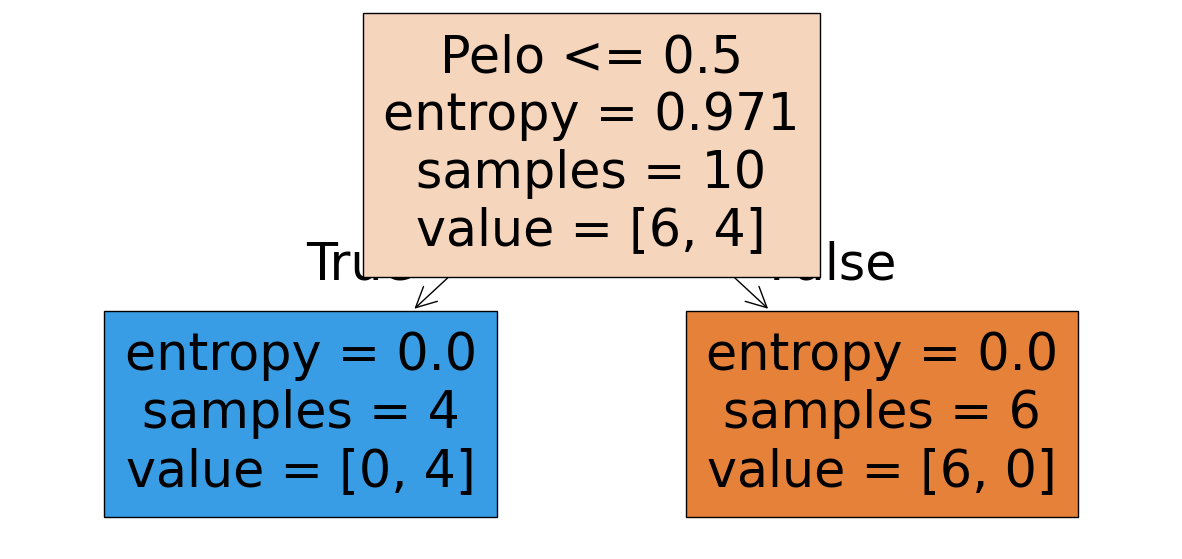

In [4]:
plt.figure(figsize=(15, 7))
# tree.plot_tree?
tree.plot_tree(model, feature_names=[
               "Dientes", "Pelo", "Respira", "Piernas"], filled=True)
plt.show()

## Ahora entendamos un poco

Entropía $H$:

Medida de impureza de un conjunto de datos. La ganancia de información se refleja en un decrecimiento en la medida de entropía.

Definición:

$H(Q_m) = - \sum_{k \in target} P_{mk} log_2(P_{mk})$,

donde $Q_m$ son los datos en el nodo $m$ del árbol, la suma se extiende sobre los posibles valores $k$ de la variable respuesta y $P_{mk}$ es la probabilidad condicional que la variable respuesta tome el valor $k$ dado a que estamos en el nodo $m$

Caso Gini: $H(Q_m) = \sum_{k \in target} P_{mk} (1-P_{mk}))$

[Documentación](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation)


In [5]:
def entropia(P):
    '''
    Función que calcula medida de entropía dada una probabilidad P.
    '''
    entropy = - P * np.log2(P)
    return entropy

Para utilizar la definición de entropía debemos tener una función que estime la probabilidad con la frecuencia relativa.


In [6]:
def calc_prob(data):
    '''
    Función que calcula la probabilidad de cada clase.
    data : columna categórica de un dataframe de pandas.
    '''
    return data.value_counts()/data.shape[0]


probabilidades = calc_prob(data['Especie'])
probabilidades

Especie
Mamifero    0.6
Reptil      0.4
Name: count, dtype: float64

Con esta función, podemos calcular la entropía total de los datos en el primer nodo:


In [7]:
entropia_total = np.sum([entropia(pi) for pi in probabilidades])
print(f'La entropia total es {round(entropia_total, 3)}')

La entropia total es 0.971


Podemos ver que este valor coincide con el que declara el método `DecisionTreeClassifier` de `scikit-learn` en el árbol de decisión que obtuvimos anteriormente.

Ahora, **¿Por qué eligió la variable pelo para ramificar? ¿Cómo lo hizo?**

Para responder esto, calculemos la ganancia de entropía para cada variable descriptiva. Esto lo podemos pensar como:

$GananciaEntropia(variable_d) = Entropia_{total} - Entropia(variable_d)$

Lo que se puede escribir como:

$GananciaEntropia(variable*d) = Entropia*{total} - \sum_{t \in variable_d} P(variable_d=t) * H(variable_d=t)$

que es igual a:

$GananciaEntropia(variable_d) = Entropia_{total} - \sum_{t \in variable_d} P(variable_d=t) * (-\sum_{k \in target} P(target=k \cap variable_d = t)) * \log_2(P((target=k \cap variable_d = t)))$


In [8]:
data[data.Dientes == 1]

,Dientes,Pelo,Respira,Piernas,Especie
0,True,True,True,True,Mamifero
1,True,True,True,True,Mamifero
2,True,False,True,False,Reptil
4,True,True,True,True,Mamifero
5,True,True,True,True,Mamifero
6,True,False,False,False,Reptil
7,True,False,True,False,Reptil
8,True,True,True,True,Mamifero


In [9]:
data[data.Dientes == 0]

,Dientes,Pelo,Respira,Piernas,Especie
3,False,True,True,True,Mamifero
9,False,False,True,True,Reptil


In [10]:
# Probabilidades de ser mamífero o reptil dado que tiene dientes
P_especie_dientes = calc_prob(data[data.Dientes == 1]['Especie'])
# Probabilidades de ser mamífero o reptil dado que no tiene dientes
P_especie_nodientes = calc_prob(data[data.Dientes == 0]['Especie'])
# Probabilidad de tener dientes
P_dientes = calc_prob(data['Dientes'])

# entropias
entropia_dientes = P_dientes[1] * (entropia(P_especie_dientes[0]) + entropia(P_especie_dientes[1])) \
    + P_dientes[0] * (entropia(P_especie_nodientes[0]) +
                      entropia(P_especie_nodientes[1]))

entropia_dientes

0.9908868005849931

In [11]:
# información ganada
entropia_total - entropia_dientes

-0.01993620613032454

In [12]:
def ganancia_de_info(var, data=data, respuesta='Especie'):
    '''
    Función que calcula la ganancia de información utilizando la entropía como medida
    de información.

    variables de entrada:
    var (str): nombre de la variable sobre la cuál vamos a calcular la ganancia de la información.
    data (dataFrame): el conjunto de datos de donde sacar la varianza
    respuesta (str): nombre de la variable respuesta

    Devuelve la ganancia de información (float)
    '''
    probabilidades = calc_prob(data[respuesta])
    entropia_total = np.sum([entropia(pi) for pi in probabilidades])
    P_especie_var = calc_prob(data[respuesta][data[var] == 1])
    P_especie_novar = calc_prob(data[respuesta][data[var] == 0])
    P_var = calc_prob(data[var])

    entropia_var = P_var[1] * np.sum([entropia(pi) for pi in P_especie_var]) \
        + P_var[0] * np.sum([entropia(pi) for pi in P_especie_novar])
    return entropia_total - entropia_var


print(f'ganancia de información variable dientes: {
      ganancia_de_info("Dientes"):.3f}')
print(f'ganancia de información variable pelo: {ganancia_de_info("Pelo"):.3f}')
print(f'ganancia de información variable respira: {
      ganancia_de_info("Respira"):.3f}')
print(f'ganancia de información variable piernas: {
      ganancia_de_info("Piernas"):.3f}')

ganancia de información variable dientes: -0.020
ganancia de información variable pelo: 0.971
ganancia de información variable respira: 0.879
ganancia de información variable piernas: 0.793


In [13]:
# recordemos que las variables son ["Dientes","Pelo","Respira","Piernas"]
animal_raro_1 = [0, 0, 0, 0]
animal_raro_2 = [1, 1, 0, 0]
model.predict([animal_raro_1, animal_raro_2])

array(['Reptil', 'Mamifero'], dtype=object)

# Caso un poco más complejo


In [14]:
# cargamos los datos
iris = datasets.load_iris()
X, y = iris.data, iris.target

# armamos dataframe para visualizar
df = pd.DataFrame(X, columns=iris.feature_names)
df['Especie'] = y
df['Especie'].replace({0: 'setosa', 1: 'versicolor', 2: 'virginica'},
                      inplace=True)

print(iris.target_names)
print(iris.feature_names)
df

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Especie
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### Regiones de decisión

Para facilitar la comprensión, lo que vamos a hacer es sólo generar un modelo de clasificación teniendo en cuenta únicamente las características del sépalo. Como son dos variables, podremos ver exactamente las regiones de decisión en un gráfico bidimensional (sin tener que fijar las otras variables).


The prediction accuracy is:  86.0 %


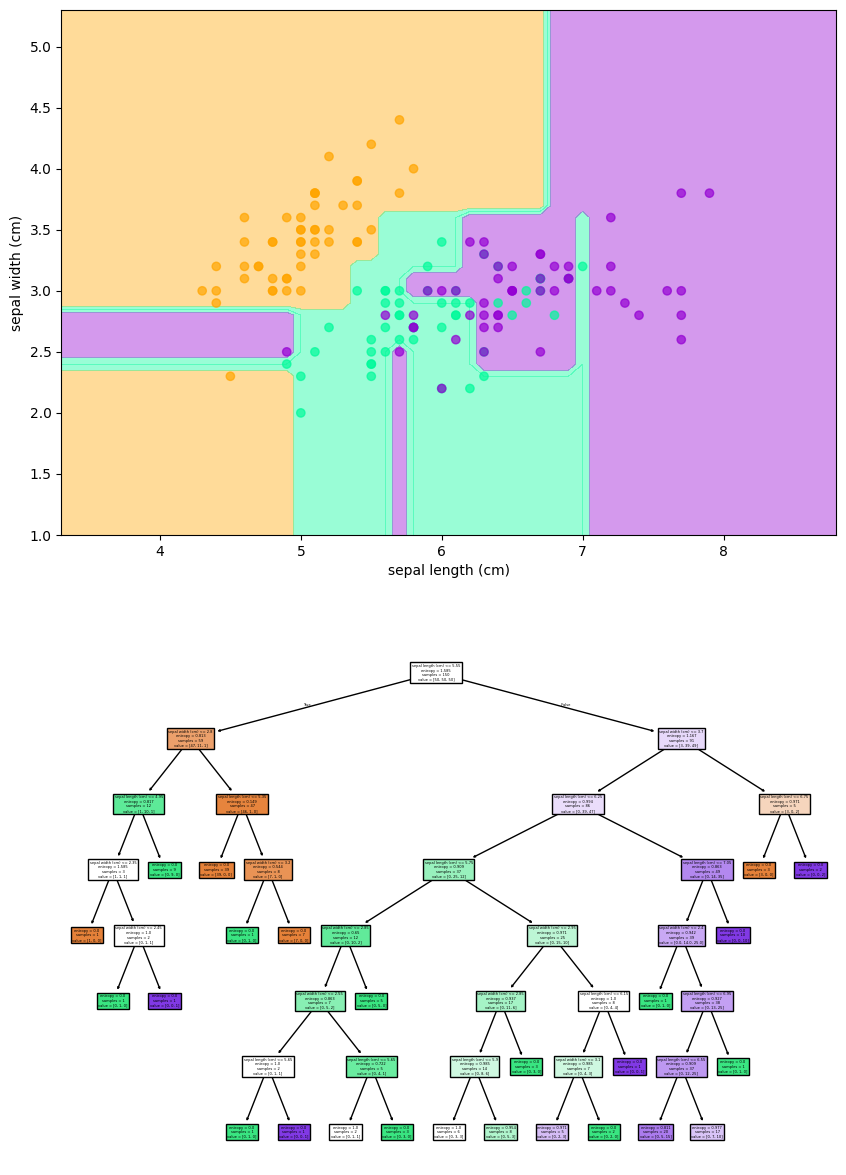

In [15]:
X1 = X[:, :2]
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                  random_state=1)
clf.fit(X1, y)

print("The prediction accuracy is: ", clf.score(X1, y)*100, "%")
# Busco los valores máximos y mínimos de las variables de sépalo
x_min, x_max = iris.data[:, 0].min() - 1, iris.data[:, 0].max() + 1
y_min, y_max = iris.data[:, 1].min() - 1, iris.data[:, 1].max() + 1

# Armo grilla de puntos donde vamos a predecir para armar las regiones
xx1, xx2 = np.meshgrid(np.arange(x_min, x_max, 0.1),
                       np.arange(y_min, y_max, 0.1))
Z2 = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z2 = Z2.reshape(xx1.shape)

plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
cmap = ListedColormap(["orange", "mediumspringgreen", "darkviolet"])
plt.contourf(xx1, xx2, Z2, alpha=0.4, cmap=cmap, levels=3)

# defino los colores necesarios para que quede más bonito y consistente con los colores del árbol.
cmap = ListedColormap(["mediumspringgreen", "darkviolet"])
ycolor = []
for caso in y:
    if caso == 0:
        ycolor.append("orange")
    elif caso == 1:
        ycolor.append("mediumspringgreen")
    elif caso == 2:
        ycolor.append("darkviolet")
    else:
        ycolor.append(np.nan)

# Agregamos todos los otros datos, pero más suavecitos. El valor de alpha determina la transparencia.
plt.scatter(df['sepal length (cm)'],
            df['sepal width (cm)'], c=ycolor, alpha=0.7)
# Agregamos formato al primer gráfico
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')


plt.subplot(2, 1, 2)
tree.plot_tree(clf,
               feature_names=iris.feature_names[:2],
               filled=True)
plt.show()

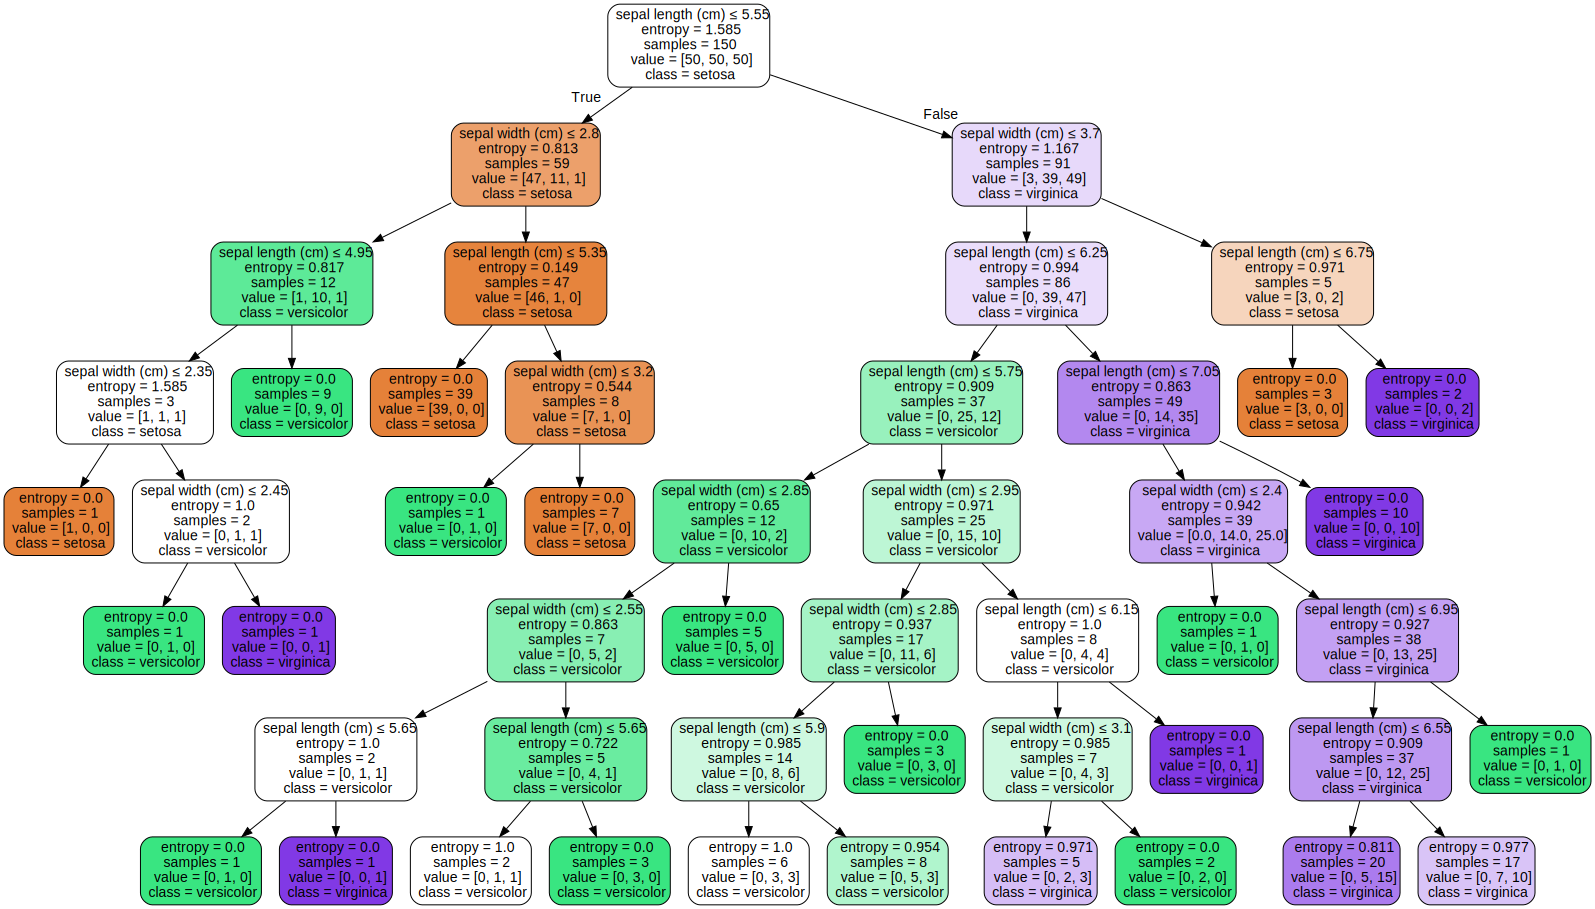

In [16]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=iris.feature_names[:2],
                                class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

Otra forma de inspeccionar el árbol es el método `export_text` del módulo `tree` de `sklearn` que permite visualizar el árbol de decisión en texto. A partir de inspeccionar el árbol de decisión, podemos entender la forma de las regiones de decisión.


In [17]:
print(tree.export_text(clf, feature_names=iris.feature_names[:2]))

|--- sepal length (cm) <= 5.55
|   |--- sepal width (cm) <= 2.80
|   |   |--- sepal length (cm) <= 4.95
|   |   |   |--- sepal width (cm) <= 2.35
|   |   |   |   |--- class: 0
|   |   |   |--- sepal width (cm) >  2.35
|   |   |   |   |--- sepal width (cm) <= 2.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sepal width (cm) >  2.45
|   |   |   |   |   |--- class: 2
|   |   |--- sepal length (cm) >  4.95
|   |   |   |--- class: 1
|   |--- sepal width (cm) >  2.80
|   |   |--- sepal length (cm) <= 5.35
|   |   |   |--- class: 0
|   |   |--- sepal length (cm) >  5.35
|   |   |   |--- sepal width (cm) <= 3.20
|   |   |   |   |--- class: 1
|   |   |   |--- sepal width (cm) >  3.20
|   |   |   |   |--- class: 0
|--- sepal length (cm) >  5.55
|   |--- sepal width (cm) <= 3.70
|   |   |--- sepal length (cm) <= 6.25
|   |   |   |--- sepal length (cm) <= 5.75
|   |   |   |   |--- sepal width (cm) <= 2.85
|   |   |   |   |   |--- sepal width (cm) <= 2.55
|   |   |   |   |   |   |--- sep

## Regression Trees


En este caso el criterio de regresión suele ser el ECM

$H(Q_m)=\frac{1}{n_m}\sum_{y\in Q_m}(y-\bar{y}_m)^2$

[Documentación](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation)


In [18]:
from sklearn.datasets import fetch_california_housing
X_california, y_california = fetch_california_housing(
    return_X_y=True, as_frame=True)
california = fetch_california_housing()

In [19]:
print(california['DESCR'])  # descripción del dataset

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [20]:
X2 = california.data[:, 0]  # Usamos la feature MedInc
y2 = california.target

# Sort X and y by ascending values of X

sort_idx = X2.flatten().argsort()
X2 = X2[sort_idx].reshape(-1, 1)
y2 = y2[sort_idx]

In [21]:
clf2 = tree.DecisionTreeRegressor(max_depth=3, criterion="squared_error")
# clf2 = tree.DecisionTreeRegressor(criterion="squared_error")

clf2 = clf2.fit(X2, y2)

### Qué nos están dando las hojas del árbol en este caso?


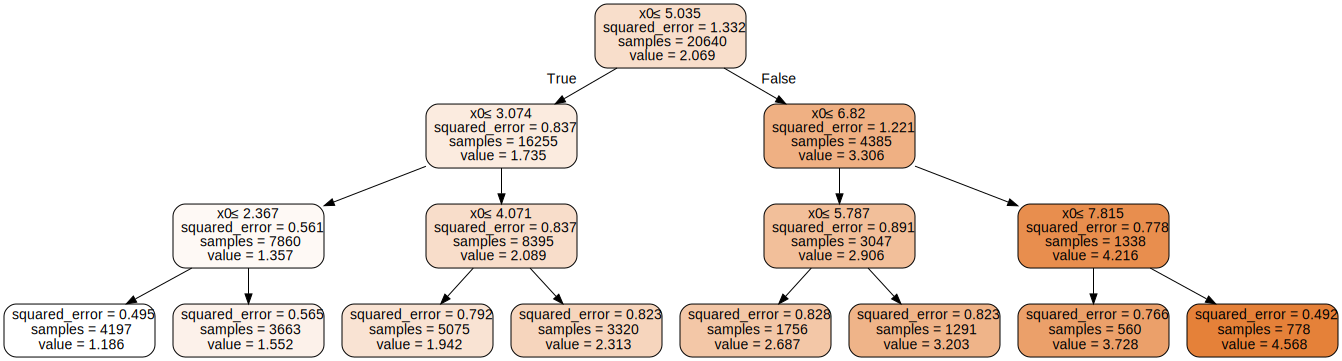

In [22]:
dot_data = tree.export_graphviz(clf2, out_file=None,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Grafiquemos


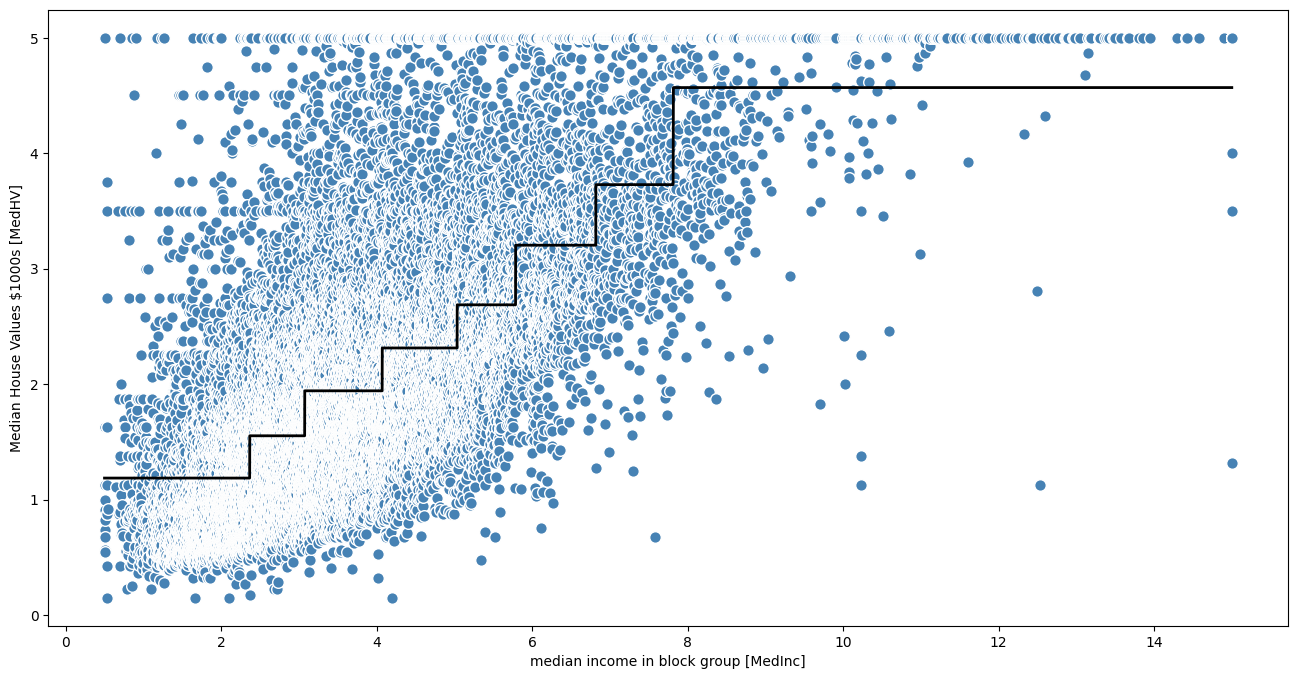

In [23]:
plt.figure(figsize=(16, 8))
plt.scatter(X2, y2, c='steelblue',
            edgecolor='white', s=70)
plt.plot(X2, clf2.predict(X2),
         color='black', lw=2)
plt.xlabel('median income in block group [MedInc]')
plt.ylabel('Median House Values $1000s [MedHV]')
plt.show()